This notebook makes the (final) version of the figure that shows the beta diversity across all site comparisons between aspirators and non-aspirators.

The beta diversity plot will be boxplots.

Note: code to make beta diversity plot is in src/figures/fig2...py, I think...

In [9]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Beta diversity

In [10]:
jsd_in = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.txt'
outfile = '../../final/figures/figure4.asp_vs_nonasp_beta.png'
outpatients = '../../final/patients/figure4.asp_vs_nonasp_beta.patients.txt'
outsamples = '../../final/patients/figure4.asp_vs_nonasp_beta.samples.txt'

## Read in data
jsd = pd.read_csv(jsd_in, sep='\t')

In [11]:
## Set up colors, orders, and kwargs
site_comparisons = ['bal-throat_swab', 'bal-gastric_fluid', 'gastric_fluid-throat_swab']

asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'nan': '#C9C9C9'}
light_pink = '#FFC9EC'
light_brown = '#E5B699'

boxprops = {'edgecolor': 'k', 'linewidth': 2.5}#, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 2.5}

kwargs = {'palette': asp_colors,
          'hue_order': ['Normal', 'Aspiration/Penetration']}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75}, 
                      **kwargs)
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.7}, 
                        **kwargs)

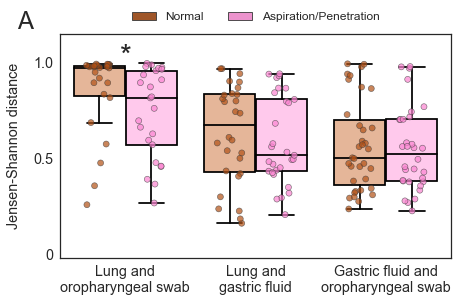

In [12]:
## Set up colors, orders, and kwargs

# Overall properties
kwargs = {'palette': asp_colors,
          'hue_order': ['Normal', 'Aspiration/Penetration']}

# Boxplot properties
boxprops = {'edgecolor': 'k'} #, #, 'facecolor': 'w'}
lineprops = {'color': 'k'} #, 'linewidth': 0.95}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops}, 
                      **kwargs)
# Stripplot properties
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.7}, 
                        **kwargs)

## Set up plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7, 4))

# JSD
# JSD dataframe has all of the possible comparisons in the entire OTU
# table. Keep just the within-subject comparisons across our sites
# of interest.
jsdtoplot = jsd.query('site_comparison == @site_comparisons')\
               .query('patient_comp == "within"')

sns.boxplot(x='site_comparison', y='beta', data=jsdtoplot,
            order=site_comparisons, hue='mbs_consolidated',
            fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site_comparison', y='beta', data=jsdtoplot,
              order=site_comparisons, hue='mbs_consolidated',
              split=True, jitter=0.2, 
              **stripplot_kwargs)

# Change face color of boxplots
for i, artist in enumerate(ax.artists):    
    if i % 2 == 1:
        artist.set_facecolor(light_pink)
    else:
        artist.set_facecolor(light_brown)

# Edit labels, etc
ax.set_ylabel('Jensen-Shannon distance', fontsize='x-large')
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([-0.01, 1.15])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize='x-large')
ax.get_yaxis().set_label_coords(-0.1,0.5)
ax.set_xticklabels(['Lung and\noropharyngeal swab', 
                    'Lung and\ngastric fluid', 
                    'Gastric fluid and\noropharyngeal swab', 
                    'Oropharyngeal swab\nand stool'],
                  fontsize='x-large')

txt = ax.text(-0.11, 1.025, 'A', transform=ax.transAxes, fontsize=24)

## P value indicators
ax.text(-0.05, 0.99, '*', fontsize='30')

## Get rid of legend
plot_legend = True

if plot_legend:
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles[0:2], labels[0:2], 
                  #loc=(0, 0), 
                  loc='upper center', 
                  fontsize='large',
                  bbox_to_anchor=(0.5, 1.15), 
                  ncol=2)
    lgd.legendHandles[0]._sizes = [40]
    lgd.legendHandles[1]._sizes = [40]
else:
    ax.legend_.remove()

fig.savefig(outfile)

### P values

In [13]:
## P-values
from scipy.stats import ranksums

asp = 'Aspiration/Penetration'
nml = 'Normal'

# Not paired, probably non-parametric? Shouldn't matter much I think...
for s in site_comparisons:
    
    n = jsdtoplot.query('site_comparison == @s').query('mbs_consolidated == @nml')['beta']
    a = jsdtoplot.query('site_comparison == @s').query('mbs_consolidated == @asp')['beta']
    
    print(s, ranksums(n, a))

('bal-throat_swab', RanksumsResult(statistic=2.0740762688776808, pvalue=0.03807222815052707))
('bal-gastric_fluid', RanksumsResult(statistic=0.73427111361271324, pvalue=0.46278351953954389))
('gastric_fluid-throat_swab', RanksumsResult(statistic=0.28870545602072445, pvalue=0.77280678711778061))


### Patients involved in this plot

In [14]:
# First goal: show the number of patients in each box
print(jsdtoplot.groupby(['site_comparison', 'mbs_consolidated']).size())

# Second goal: write all of the patients
with open(outpatients, 'w') as f:
    f.write('\n'.join(jsdtoplot['subject'].unique()))

site_comparison            mbs_consolidated      
bal-gastric_fluid          Aspiration/Penetration    29
                           Normal                    28
bal-throat_swab            Aspiration/Penetration    25
                           Normal                    23
gastric_fluid-throat_swab  Aspiration/Penetration    32
                           Normal                    35
dtype: int64


In [15]:
jsdtoplot[['batch1', 'batch2']].drop_duplicates()

,batch1,batch2
1,2016,2016
13365,2014,2014


### Samples in this plot

In [23]:
jsd_samples = jsdtoplot.dropna(subset=['mbs_consolidated'])
samples = list(set(jsd_samples['sample1'].tolist() + jsd_samples['sample2'].tolist()))
with open(outsamples, 'w') as f:
    f.write('\n'.join(samples))

# Unused plots

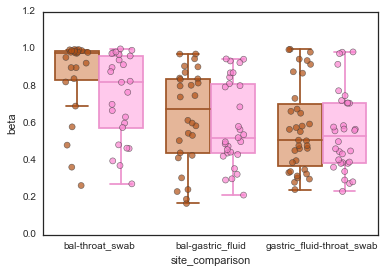

In [17]:
## Set up plot
sns.set_style('white')
fig, ax = plt.subplots()

# JSD
# JSD dataframe has all of the possible comparisons in the entire OTU
# table. Keep just the within-subject comparisons across our sites
# of interest.
jsdtoplot = jsd.query('site_comparison == @site_comparisons')\
               .query('patient_comp == "within"')

sns.boxplot(x='site_comparison', y='beta', data=jsdtoplot,
            order=site_comparisons, hue='mbs_consolidated',
            fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site_comparison', y='beta', data=jsdtoplot,
              order=site_comparisons, hue='mbs_consolidated',
              split=True, jitter=0.2, 
              **stripplot_kwargs)

ax.legend_.remove()

for i, artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    if i % 2 == 1:
        artist.set_facecolor(light_pink)
    else:
        artist.set_facecolor(light_brown)

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

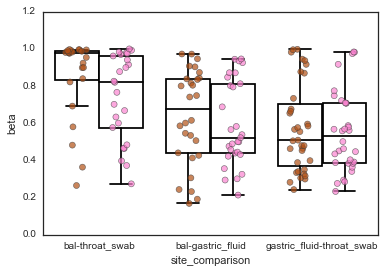

In [18]:
## Set up colors, orders, and kwargs
asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'nan': '#C9C9C9'}
boxprops = {'edgecolor': 'k', 'facecolor': 'w'}
lineprops = {'color': 'k'}

kwargs = {'palette': asp_colors,
          'hue_order': ['Normal', 'Aspiration/Penetration']}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops}, 
                      **kwargs)
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.7}, 
                        **kwargs)

## Set up plot
sns.set_style('white')
fig, ax = plt.subplots()

# JSD
# JSD dataframe has all of the possible comparisons in the entire OTU
# table. Keep just the within-subject comparisons across our sites
# of interest.
jsdtoplot = jsd.query('site_comparison == @site_comparisons')\
               .query('patient_comp == "within"')

sns.boxplot(x='site_comparison', y='beta', data=jsdtoplot,
            order=site_comparisons, hue='mbs_consolidated',
            fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site_comparison', y='beta', data=jsdtoplot,
              order=site_comparisons, hue='mbs_consolidated',
              split=True, jitter=0.2, 
              **stripplot_kwargs)

ax.legend_.remove()


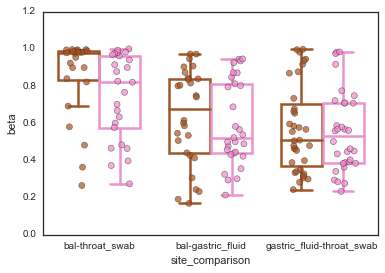

In [19]:
## Set up colors, orders, and kwargs
asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'nan': '#C9C9C9'}
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}#, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 2.5}

kwargs = {'palette': asp_colors,
          'hue_order': ['Normal', 'Aspiration/Penetration']}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75}, 
                      **kwargs)
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.7}, 
                        **kwargs)

## Set up plot
sns.set_style('white')
fig, ax = plt.subplots()

# JSD
# JSD dataframe has all of the possible comparisons in the entire OTU
# table. Keep just the within-subject comparisons across our sites
# of interest.
jsdtoplot = jsd.query('site_comparison == @site_comparisons')\
               .query('patient_comp == "within"')

sns.boxplot(x='site_comparison', y='beta', data=jsdtoplot,
            order=site_comparisons, hue='mbs_consolidated',
            fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site_comparison', y='beta', data=jsdtoplot,
              order=site_comparisons, hue='mbs_consolidated',
              split=True, jitter=0.2, 
              **stripplot_kwargs)

ax.legend_.remove()


light_pink = '#FFC9EC'
light_brown = '#E5B699'

for i, artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)